In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV,GroupKFold
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import holidays
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt



In [2]:
# Import datasets

ssub= '/kaggle/input/digital-turbine-auction-bid-price-prediction/sample_submission.csv'
train= '/kaggle/input/digital-turbine-auction-bid-price-prediction/train_data.csv'
test= '/kaggle/input/digital-turbine-auction-bid-price-prediction/test_data.csv'

train=pd.read_csv(train)
test=pd.read_csv(test)
ssub=pd.read_csv(ssub)



Below is quite a big grid for GridSearchCV (the reason why it can't be run using the simple Kaagle Computing Resources). It would need optimization (parallelization/ numbda).  A lot can be done to make it better, and I will probably return to this notebook during my free time.


# **EDA**

In [3]:

train=train.sample(10000,random_state=20)
test=test.sample(10000,random_state=30)

In [4]:
# Perform EDA with the use of pandas_profiling

!pip install pandas-profiling > /dev/null
from pandas_profiling import ProfileReport
EDA=ProfileReport(train)
EDA

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.9.3 which is incompatible.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Takeaway points:

* 6509155 vs 812478 for has_won==1
* 23008 distinct in winBid
* sentPrice = high correlation with winBid
* Possible use of c1-c4 due the high correlation with other features
* Most people use Android - sad truth
* DT won ~12% of all auctions from the training set - not bad! 

<Axes: >

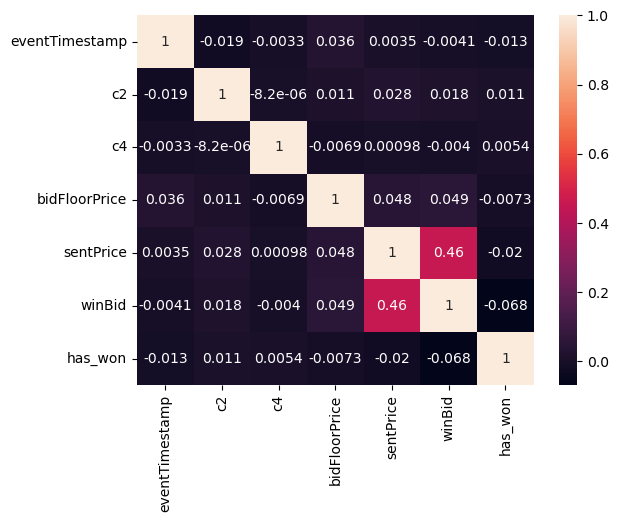

In [5]:
# Check colinearity between continous variables

cols=[]
for column in train.columns:
    if train[column].dtypes == int or train[column].dtypes == np.int64 or train[column].dtypes ==np.float64:
        cols.append(column)

sns.heatmap(train[cols].corr(),annot=True)


relationship between wind and sentPrice is not shocking. The rest of the features seem not to have a collinearity

In [6]:
# Check how many unique categories we have in each cetegorical variable

for i,v in train[['unitDisplayType','brandName','bundleId','appVersion','correctModelName','countryCode']].iteritems():
    print(i,len(v.unique()))

unitDisplayType 3
brandName 56
bundleId 18
appVersion 53
correctModelName 867
countryCode 99


In [7]:
# Check for NaN's'
pd.DataFrame(train.isna().sum(),columns=['Nans']).sort_values(by='Nans',ascending=False)


,Nans
connectionType,5
eventTimestamp,0
c2,0
winBid,0
sentPrice,0
bidFloorPrice,0
mediationProviderVersion,0
size,0
c4,0
c3,0


In [8]:
# Create a Human Readable date and time out of timestamp

def create_HRD(df):
    df['HRdate']=pd.to_datetime(df['eventTimestamp'], unit='ms').dt.date
    df['HRtime']=pd.to_datetime(df['eventTimestamp'], unit='ms').dt.time
    return df

In [9]:
# apply the function to create HRD and HRT

train=create_HRD(train)
test=create_HRD(test)

In [10]:
# Check the distribution if CountryCode == NaN and extract unique dates

train[train['countryCode'].isna()==True]['HRdate'].value_counts()
Nans=train[train['countryCode'].isna()==True]['HRdate'].reset_index()
Nans=Nans['HRdate'].unique()
Nans

array([], dtype=object)

The idea was to find a simple way to interpolate on NaNs in the countryCode column. The possibility that "Unknown" country is equal to the country with the highest prevalence of the requests on the same day, seems to be higher than simple forward fill.



In [11]:
# Find out which category was most frequent in case of the same dates

filtered_train = train[train['HRdate'].isin(Nans)]
grouped = filtered_train.groupby(['HRdate', 'countryCode'])
pd.DataFrame(grouped.size(),columns=['Freq']).groupby('HRdate').idxmax()

# Fill NaNs with the country with highest propensity

train['countryCode'].fillna('US',inplace=True)


# important notice: relative distribution should be used during next iteration

In [12]:
# Check if countryCode NaNs were filled

pd.DataFrame(train.isna().sum(),columns=['Nans']).sort_values(by='Nans',ascending=False)


,Nans
connectionType,5
eventTimestamp,0
c3,0
HRdate,0
has_won,0
winBid,0
sentPrice,0
bidFloorPrice,0
mediationProviderVersion,0
size,0


# **Feature Engineering**

In [13]:
def feature_engineering(group):


# How many changes in app version were made compared to previous auction and how many changes were made overall
    
    group['switch_app'] = group['osAndVersion'].ne(group['osAndVersion'].shift()).astype(int)
    group['switch_app_sum'] = group['osAndVersion'].nunique()

# How many changes in phone model were made compared to previous auction and how many changes were made overall

    group['switch_phone'] = group['correctModelName'].ne(group['correctModelName'].shift()).astype(int)
    group['switch_phone_sum'] = group['correctModelName'].nunique()

# How many changes in phone brand were made compared to previous auction and how many changes were made overall

    group['switch_brand'] = group['brandName'].ne(group['brandName'].shift()).astype(int)
    group['switch_brand_sum'] = group['brandName'].nunique()

# Is current ad slot time is most common for this deviceId
    
    group['most_common_dt'] = (group['unitDisplayType'] == group['unitDisplayType'].value_counts().idxmax()).astype(int)

# Is sent_price higher than mean
    
    group['sent_price_to_mean']=(group['sentPrice']>group['sentPrice'].mean()).astype(int)

# Is sent_price higher than mean for the same day
    
    group['sent_price_to_mean_day'] = (group['sentPrice'] > group.groupby('HRdate')['sentPrice'].transform('mean')).astype(int)

# Average sent price for this ID
    
    group['avg_sent_price']=group['sentPrice'].mean()

# Average sent_price for this ID and day
    
    group['avg_sent_price_day']=group.groupby('HRdate')['sentPrice'].transform('mean')

# Max sent_price for this ID
    
    group['max_sent_price']=group['sentPrice'].max()

# Max sent_price for this ID and day
    
    group['max_sent_price_day']=group.groupby('HRdate')['sentPrice'].transform('max')

# Date features
    
    group['HRdate']=pd.to_datetime(group['HRdate'])
    group['Month'] = group['HRdate'].dt.month
    group['Day'] = group['HRdate'].dt.day
    group['Day_of_week'] = group['HRdate'].dt.dayofweek
    group['Quarter'] = group['HRdate'].dt.quarter
    group['Is_weekday'] = (group['HRdate'].dt.dayofweek < 5).astype(int)
    group['is_weekend'] = group['HRdate'].dt.dayofweek.isin([5, 6]).astype(int)


# Some features extracted from an anonymized columns
    
    group['dif_sent_floor'] = group['sentPrice'] - group['bidFloorPrice']
    group['c2_plus_c4'] = group['c2'] + group['c4']
    group['diff_c2_c4'] = group['c2'] - group['c4']
    group['diff_c2_c4'] = group['c2'] / group['c4']
    group['multop_c2_c4'] = group['c2'] * group['c4']

    return group

In [14]:
# Sort by date for each deviceID - necessery to extract correct features realted to the temporal order

train=train.groupby('deviceId',as_index=False,sort=False).apply(lambda x: x.sort_values(by=['HRdate','HRtime'],ascending=True))
test=test.groupby('deviceId',as_index=False,sort=False).apply(lambda x: x.sort_values(by=['HRdate','HRtime'],ascending=True))

# Apply Feature engineering function

train,test=train.groupby('deviceId').apply(lambda x:feature_engineering(x)),test.groupby('deviceId').apply(lambda x:feature_engineering(x))

In [15]:
# save deviceId form test

ID_from_test=test['deviceId']

In [16]:
# Check the shape

print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (10000, 45)
Test shape (10000, 43)


In [17]:
import gc
gc.collect()

0

# **Encoding**

In [18]:
# Encode categorical variables

merged_data = pd.concat([train, test], axis=0, ignore_index=True)

categorical_cols = []
for col_name, col_data in merged_data.iteritems():
    if col_data.dtype == object and col_name != 'HRtime':
        categorical_cols.append(col_name)
merged_data[categorical_cols] = merged_data[categorical_cols].astype(str)


encoder = OrdinalEncoder()
merged_data[categorical_cols] = encoder.fit_transform(merged_data[categorical_cols])


train = merged_data[:len(train)]
test = merged_data[len(train):]

test.drop(['has_won', 'winBid'], axis=1, inplace=True)
print(categorical_cols)

['unitDisplayType', 'brandName', 'bundleId', 'appVersion', 'correctModelName', 'countryCode', 'deviceId', 'osAndVersion', 'connectionType', 'c1', 'c3', 'size', 'mediationProviderVersion']


In [19]:
# Check the shape again

print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (10000, 45)
Test shape (10000, 43)


# **Model**

Selected estimator = Light Gradient Boosting Machine Regressor (typically way better than simple XGBoost on similar problems) with hyperparameter tuning based on GridSearchCV and groupKfold for a balanced distribution of groups across the folds. I have removed the verbosity for clearance 


In [20]:


estimator = lgb.LGBMRegressor(random_state=42,metric='l2',verbose=-1)

best_rmse=np.inf
validation=[]
callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=0)]


param_grid = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 150],
    'num_leaves': [10, 20],
    'max_depth': [5, 10],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'min_child_samples': [10, 20],
    'subsample': [0.6, 0.7]
}

n_splits = 3

groups = train['deviceId']
gkf = GroupKFold(n_splits=n_splits)


X_train = train.drop(labels=['has_won','winBid','HRdate','HRtime','eventTimestamp'], axis=1)
y_train = train['winBid']

categorical_features_no = [X_train.columns.get_loc(col) for col in categorical_cols]

for train_index, test_index in gkf.split(X_train, y_train, groups):
    X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[test_index]


    # Perform GridSearchCV for Hyperparameters tuning

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=n_splits,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error',
        verbose=-1,
        return_train_score=True,
        
    )

    grid_search.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val_split, y_val_split)],
        eval_metric='neg_root_mean_squared_error',
        callbacks=callbacks

    )

    # extract best hyperparameters found by minimizing of RMSE
    
    cv_results = grid_search.cv_results_
    mean_train_rmse = -np.mean(cv_results['mean_test_score'])
    validation.append(mean_train_rmse)

    if mean_train_rmse < best_rmse:
        best_params = grid_search.best_params_
        best_rmse = mean_train_rmse

final_model=lgb.LGBMRegressor(random_state=42,**best_params,metric='l2')
final_model.fit(X_train, y_train)

# Make predictions on the test data using the best model
y_pred = final_model.predict(test.drop(['HRtime', 'HRdate','eventTimestamp'], axis=1))

# Save the predictions and IDs

dev_ID = pd.Series(ID_from_test.values)

final_predictions_df = pd.DataFrame({'deviceId':dev_ID,'winBid': y_pred})
final_predictions_df.to_csv('submission.csv')

In [21]:
# mean validation RMSE's from each fold from GroupKFold

validation

[17.03345107903041, 17.399615704546566, 17.323306041610003]

In [22]:
final_predictions_df

,deviceId,winBid
0,804ef112f57,0.464480
1,802043ab5e2,0.353885
2,74cd4a0ada9,0.353885
3,74f0f58de64,6.910226
4,80b16558a12,0.464480
...,...,...
9995,80de6c315e9,59.076783
9996,80e29221b0b,5.594514
9997,7413f275f14,1.064587
9998,6ab37f7dc0d,1.064587


In [23]:
# Possible upgrade:

# Remove sparse deviceID with less or equal than 5% of the rows for sentPrice variable (based on total distribution)

# count_dID=pd.DataFrame(train.groupby('deviceId')['sentPrice'].count())
# threshold=train.groupby('deviceId')['sentPrice'].count().quantile(0.05)
# sparse_dID=count_dID[count_dID['sentPrice']<=threshold]
# print(str(len(sparse_dID))+' devicesID will be removed, threshold = ' + str(int(threshold)) + ' rows')
# sparse_idx=sparse_dID.index
# train=train.query('deviceId not in @sparse_idx')